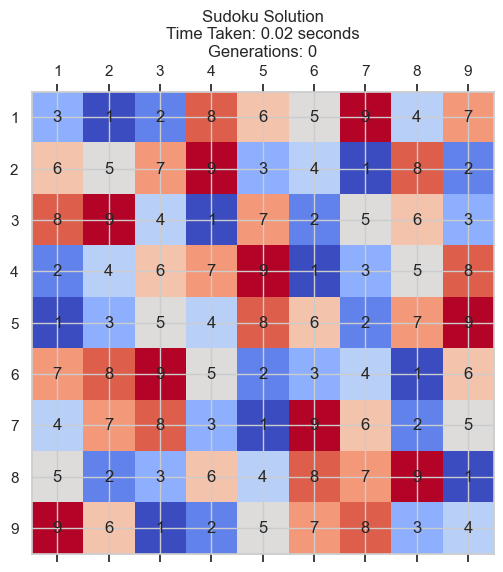

In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Set the aesthetics for the plot
sns.set(style="whitegrid", palette="pastel", color_codes=True)

# Example Sudoku board (0 represents empty cells)
sudoku_board = [
    [3, 0, 2, 0, 6, 5, 0, 4, 7],
    [0, 5, 0, 0, 3, 4, 1, 8, 2],
    [0, 9, 0, 1, 7, 0, 0, 6, 0],
    [2, 0, 6, 0, 9, 0, 3, 0, 8],
    [1, 0, 0, 0, 0, 0, 2, 7, 0],
    [0, 8, 9, 5, 0, 3, 4, 0, 0],
    [4, 7, 0, 3, 0, 0, 0, 0, 5],
    [0, 0, 0, 6, 4, 8, 0, 9, 1],
    [0, 0, 0, 2, 0, 0, 0, 0, 0]
]

# Convert to a NumPy array for convenience
board = np.array(sudoku_board)

def fitness(candidate):
    score = 0
    for row in range(9):
        score += len(set(candidate[row]))  # Row uniqueness
    for col in range(9):
        score += len(set(candidate[:, col]))  # Column uniqueness
    for box_row in range(3):
        for box_col in range(3):
            subgrid = candidate[box_row*3:(box_row+1)*3, box_col*3:(box_col+1)*3]
            score += len(set(subgrid.flatten()))  # Subgrid uniqueness
    return score

def initialize_population(board, population_size=100):
    population = []
    for _ in range(population_size):
        candidate = np.copy(board)
        for row in range(9):
            for col in range(9):
                if candidate[row][col] == 0:
                    possible_values = list(set(range(1, 10)) - set(candidate[row]) - set(candidate[:, col]) - set(candidate[row//3*3:(row//3+1)*3, col//3*3:(col//3+1)*3].flatten()))
                    candidate[row][col] = random.choice(possible_values) if possible_values else random.randint(1, 9)
        population.append(candidate)
    return population

def select_parents(population, fitnesses, num_parents=10):
    fitness_prob = fitnesses / np.sum(fitnesses)
    parent_indices = np.random.choice(len(population), size=num_parents, p=fitness_prob)
    parents = [population[i] for i in parent_indices]
    return parents

def crossover(parent1, parent2):
    crossover_point = random.randint(0, 8)
    child1 = np.copy(parent1)
    child2 = np.copy(parent2)
    for i in range(crossover_point, 9):
        child1[:, i], child2[:, i] = child2[:, i], child1[:, i]
    return child1, child2

def mutate(candidate, mutation_rate=0.1):
    for row in range(9):
        for col in range(9):
            if candidate[row][col] == 0 and random.random() < mutation_rate:
                possible_values = list(set(range(1, 10)) - set(candidate[row]) - set(candidate[:, col]) - set(candidate[row//3*3:(row//3+1)*3, col//3*3:(col//3+1)*3].flatten()))
                candidate[row][col] = random.choice(possible_values) if possible_values else random.randint(1, 9)
    return candidate

def evolve_population(population, num_generations=1000, mutation_rate=0.1, elite_size=5):
    for generation in range(num_generations):
        fitnesses = np.array([fitness(candidate) for candidate in population])
        if np.max(fitnesses) == 243:
            return population[np.argmax(fitnesses)], generation
        elite_indices = np.argsort(fitnesses)[-elite_size:]
        elites = [population[i] for i in elite_indices]
        parents = select_parents(population, fitnesses)
        new_population = []
        for i in range(0, len(parents), 2):
            parent1, parent2 = parents[i], parents[i+1]
            child1, child2 = crossover(parent1, parent2)
            new_population.extend([mutate(child1, mutation_rate), mutate(child2, mutation_rate)])
        population = elites + new_population[:len(population)-elite_size]
    best_candidate = population[np.argmax(fitnesses)]
    return best_candidate, num_generations

# Initialize population
population = initialize_population(board)

# Measure the start time
start_time = time.time()

# Evolve population to solve Sudoku
solved_board, generation = evolve_population(population)

# Measure the end time
end_time = time.time()

# Time taken to solve
time_taken = end_time - start_time

def plot_sudoku(board):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(board, cmap='coolwarm')

    for i in range(9):
        for j in range(9):
            c = board[j, i]
            if c != 0:
                ax.text(i, j, str(c), va='center', ha='center')

    plt.xticks(np.arange(9), labels=np.arange(1, 10))
    plt.yticks(np.arange(9), labels=np.arange(1, 10))
    plt.title(f'Sudoku Solution\nTime Taken: {time_taken:.2f} seconds\nGenerations: {generation}')

    plt.show()

# Plot the solved Sudoku board
plot_sudoku(solved_board)





Solved in generation 229, time used is 13.088618278503418


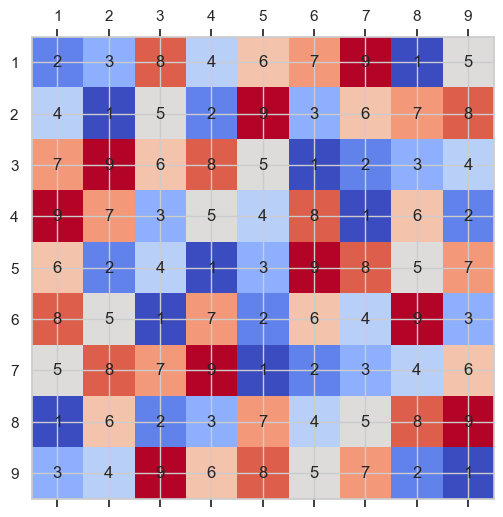

In [45]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from typing import List, Tuple

# Set the aesthetics for the plot
sns.set(style="whitegrid", palette="pastel", color_codes=True)

# Simple Sudoku class to handle Sudoku puzzles
class Sudoku:
    def __init__(self, sudoku_string: str):
        self.np_Sudoku = self.parse_sudoku_string(sudoku_string)
    
    @staticmethod
    def parse_sudoku_string(sudoku_string: str) -> np.ndarray:
        lines = sudoku_string.strip().split()
        board = [[int(char) for char in line] for line in lines]
        return np.array(board)

def get_nine_blocks(np_Sudoku):
    nine_blocks = []
    for i in range(3):
        for j in range(3):
            block = np_Sudoku[i*3:(i+1)*3, j*3:(j+1)*3]
            nine_blocks.append(block)
    return nine_blocks

def convert_nine_blocks_to_sukudo(nine_blocks):
    np_Sudoku = np.zeros((9, 9), dtype=int)
    for i in range(3):
        for j in range(3):
            np_Sudoku[i*3:(i+1)*3, j*3:(j+1)*3] = nine_blocks[i*3 + j]
    return np_Sudoku

def which_block_it_is(row, col):
    return (row // 3) * 3 + (col // 3)

def mask_for_given_sudoku_val(np_Sudoku):
    return (np_Sudoku != 0).astype(int)

def generate_empty_coord(board):
    return [(i, j) for i in range(9) for j in range(9) if board[i, j] == 0]

def show_sudoku_filled(sudoku):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(sudoku, cmap='coolwarm')

    for i in range(9):
        for j in range(9):
            c = sudoku[j, i]
            if c != 0:
                ax.text(i, j, str(c), va='center', ha='center')

    plt.xticks(np.arange(9), labels=np.arange(1, 10))
    plt.yticks(np.arange(9), labels=np.arange(1, 10))
    plt.show()

def get_error_from_updated_sukudo(sudoku):
    error_count = 0
    for i in range(9):
        error_count += 9 - len(set(sudoku[i, :]))
        error_count += 9 - len(set(sudoku[:, i]))
    for block in get_nine_blocks(sudoku):
        error_count += 9 - len(set(block.flatten()))
    return error_count, sudoku

def randomly_flip_numbers_in_a_block(np_Sudoku, nine_block_masks, block_num):
    updated_sudoku_9_blocks = get_nine_blocks(np_Sudoku)
    one_block_mask = nine_block_masks[block_num]
    row_col_combo_unfilled = return_row_col_combo_unfilled(one_block_mask)
    swap_position1 = random.choice(row_col_combo_unfilled)
    row_col_combo_unfilled.remove(swap_position1)
    swap_position2 = random.choice(row_col_combo_unfilled)
    tmp = updated_sudoku_9_blocks[block_num][swap_position1[0]][swap_position1[1]]
    updated_sudoku_9_blocks[block_num][swap_position1[0]][swap_position1[1]] = updated_sudoku_9_blocks[block_num][swap_position2[0]][swap_position2[1]]
    updated_sudoku_9_blocks[block_num][swap_position2[0]][swap_position2[1]] = tmp
    updated_soduku = convert_nine_blocks_to_sukudo(updated_sudoku_9_blocks)
    return updated_soduku

def return_row_col_combo_unfilled(one_block_mask):
    row_col_combo_unfilled = list()
    for row in range(3):
        for col in range(3):
            if one_block_mask[row][col] == 0:
                row_col_combo_unfilled.append((row, col))
    return row_col_combo_unfilled

def fill_in_np_sudoku(np_Sudoku, empty_coord):
    nine_blocks = get_nine_blocks(np_Sudoku)
    for key in empty_coord:
        block_num = which_block_it_is(key[0], key[1])
        nums_to_choose = list(range(1, 10))
        nums_to_choose = [i for i in nums_to_choose if i not in set(list(nine_blocks[block_num].ravel()))]
        num_to_fill = np.random.choice(nums_to_choose)
        np_Sudoku[key[0]][key[1]] = num_to_fill
    return np_Sudoku

def cross_over(for_cross_over):
    new_cross_over_boards = list()
    new_cross_over_boards.append(np.concatenate((for_cross_over[-1][:6], for_cross_over[0][6:]), axis=0))
    for i in range(len(for_cross_over) - 1):
        new_solution = np.concatenate((for_cross_over[i][:6], for_cross_over[i + 1][6:]), axis=0)
        new_cross_over_boards.append(new_solution)
    return new_cross_over_boards

def mutation(for_mutation, nine_block_mask):
    new_mutation_boards = list()
    for board in for_mutation:
        block_num = random.choice(range(9))
        new_mutation_boards.append(randomly_flip_numbers_in_a_block(board, nine_block_mask, block_num))
    return new_mutation_boards

def genetic_algorithm(startingSudoku, population_size=100, max_generation=5000):
    start = time()
    sudoku_obj = Sudoku(startingSudoku)
    sudoku_mask = mask_for_given_sudoku_val(sudoku_obj.np_Sudoku)
    nine_block_mask = get_nine_blocks(sudoku_mask)
    generation = 0
    boards_to_solve = [sudoku_obj.np_Sudoku.copy() for _ in range(population_size)]
    empty_coord_lst = [generate_empty_coord(board) for board in boards_to_solve]
    updated_boards = [fill_in_np_sudoku(board, coord) for (board, coord) in zip(boards_to_solve, empty_coord_lst)]

    for generation in range(max_generation):
        updated_boards_errors = [get_error_from_updated_sukudo(board)[0] for board in updated_boards]
        updated_boards_ordered = [board for board in map(lambda x: x[1], sorted(zip(updated_boards_errors, updated_boards), key=lambda x: x[0]))]
        min_error = get_error_from_updated_sukudo(updated_boards_ordered[0])[0]

        if min_error == 0:
            end = time()
            print(f"Solved in generation {generation}, time used is {end-start}")
            show_sudoku_filled(updated_boards_ordered[0])
            break
        else:
            new_gen = list()
            elite = updated_boards_ordered[: int(0.2 * population_size)]
            new_gen.extend(elite)
            for_cross_over = random.sample(updated_boards_ordered, int(0.4 * population_size))
            new_gen.extend(cross_over(for_cross_over))
            for_mutation = random.sample(updated_boards_ordered, int(0.4 * population_size))
            new_gen.extend(mutation(for_mutation, nine_block_mask))
            updated_boards = new_gen

            generation += 1

    if generation == max_generation:
        print(f"not solved, min error is {min_error}")
        return updated_boards_ordered[0]

# Example Sudoku puzzle
startingSudoku1 = """
                    008060900
                    000203678
                    706051004
                    973048100
                    620039050
                    001700000
                    580900306
                    000000000
                    040005721
                """

# Run the genetic algorithm
genetic_algorithm(startingSudoku1, population_size=500, max_generation=15000)



Solved in generation 69, time used is 255.2249960899353


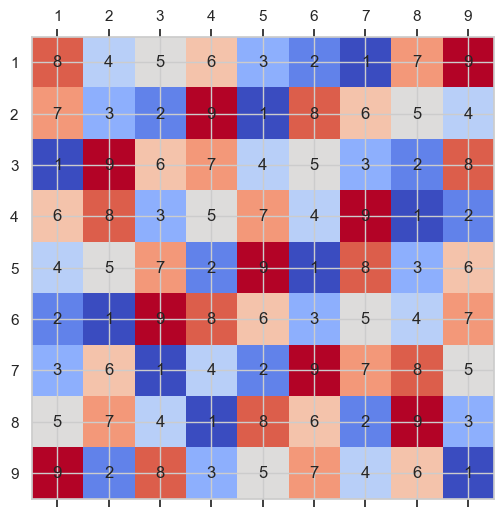

In [57]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from typing import List, Tuple

# Set the aesthetics for the plot
sns.set(style="whitegrid", palette="pastel", color_codes=True)

# Simple Sudoku class to handle Sudoku puzzles
class Sudoku:
    def __init__(self, sudoku_string: str):
        self.np_Sudoku = self.parse_sudoku_string(sudoku_string)
    
    @staticmethod
    def parse_sudoku_string(sudoku_string: str) -> np.ndarray:
        lines = sudoku_string.strip().split()
        board = [[int(char) for char in line] for line in lines]
        return np.array(board)

def get_nine_blocks(np_Sudoku):
    nine_blocks = []
    for i in range(3):
        for j in range(3):
            block = np_Sudoku[i*3:(i+1)*3, j*3:(j+1)*3]
            nine_blocks.append(block)
    return nine_blocks

def convert_nine_blocks_to_sukudo(nine_blocks):
    np_Sudoku = np.zeros((9, 9), dtype=int)
    for i in range(3):
        for j in range(3):
            np_Sudoku[i*3:(i+1)*3, j*3:(j+1)*3] = nine_blocks[i*3 + j]
    return np_Sudoku

def which_block_it_is(row, col):
    return (row // 3) * 3 + (col // 3)

def mask_for_given_sudoku_val(np_Sudoku):
    return (np_Sudoku != 0).astype(int)

def generate_empty_coord(board):
    return [(i, j) for i in range(9) for j in range(9) if board[i, j] == 0]

def show_sudoku_filled(sudoku):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(sudoku, cmap='coolwarm')

    for i in range(9):
        for j in range(9):
            c = sudoku[j, i]
            if c != 0:
                ax.text(i, j, str(c), va='center', ha='center')

    plt.xticks(np.arange(9), labels=np.arange(1, 10))
    plt.yticks(np.arange(9), labels=np.arange(1, 10))
    plt.show()

def get_error_from_updated_sukudo(sudoku):
    error_count = 0
    for i in range(9):
        error_count += 9 - len(set(sudoku[i, :]))
        error_count += 9 - len(set(sudoku[:, i]))
    for block in get_nine_blocks(sudoku):
        error_count += 9 - len(set(block.flatten()))
    return error_count, sudoku

def randomly_flip_numbers_in_a_block(np_Sudoku, nine_block_masks, block_num):
    updated_sudoku_9_blocks = get_nine_blocks(np_Sudoku)
    one_block_mask = nine_block_masks[block_num]
    row_col_combo_unfilled = return_row_col_combo_unfilled(one_block_mask)
    swap_position1 = random.choice(row_col_combo_unfilled)
    row_col_combo_unfilled.remove(swap_position1)
    swap_position2 = random.choice(row_col_combo_unfilled)
    tmp = updated_sudoku_9_blocks[block_num][swap_position1[0]][swap_position1[1]]
    updated_sudoku_9_blocks[block_num][swap_position1[0]][swap_position1[1]] = updated_sudoku_9_blocks[block_num][swap_position2[0]][swap_position2[1]]
    updated_sudoku_9_blocks[block_num][swap_position2[0]][swap_position2[1]] = tmp
    updated_soduku = convert_nine_blocks_to_sukudo(updated_sudoku_9_blocks)
    return updated_soduku

def return_row_col_combo_unfilled(one_block_mask):
    row_col_combo_unfilled = list()
    for row in range(3):
        for col in range(3):
            if one_block_mask[row][col] == 0:
                row_col_combo_unfilled.append((row, col))
    return row_col_combo_unfilled

def fill_in_np_sudoku(np_Sudoku, empty_coord):
    nine_blocks = get_nine_blocks(np_Sudoku)
    for key in empty_coord:
        block_num = which_block_it_is(key[0], key[1])
        nums_to_choose = list(range(1, 10))
        nums_to_choose = [i for i in nums_to_choose if i not in set(list(nine_blocks[block_num].ravel()))]
        num_to_fill = np.random.choice(nums_to_choose)
        np_Sudoku[key[0]][key[1]] = num_to_fill
    return np_Sudoku

def cross_over(for_cross_over):
    new_cross_over_boards = list()
    new_cross_over_boards.append(np.concatenate((for_cross_over[-1][:6], for_cross_over[0][6:]), axis=0))
    for i in range(len(for_cross_over) - 1):
        new_solution = np.concatenate((for_cross_over[i][:6], for_cross_over[i + 1][6:]), axis=0)
        new_cross_over_boards.append(new_solution)
    return new_cross_over_boards

def mutation(for_mutation, nine_block_mask):
    new_mutation_boards = list()
    for board in for_mutation:
        block_num = random.choice(range(9))
        new_mutation_boards.append(randomly_flip_numbers_in_a_block(board, nine_block_mask, block_num))
    return new_mutation_boards

def genetic_algorithm(startingSudoku, population_size=100, max_generation=5000):
    start = time()
    sudoku_obj = Sudoku(startingSudoku)
    sudoku_mask = mask_for_given_sudoku_val(sudoku_obj.np_Sudoku)
    nine_block_mask = get_nine_blocks(sudoku_mask)
    generation = 0
    boards_to_solve = [sudoku_obj.np_Sudoku.copy() for _ in range(population_size)]
    empty_coord_lst = [generate_empty_coord(board) for board in boards_to_solve]
    updated_boards = [fill_in_np_sudoku(board, coord) for (board, coord) in zip(boards_to_solve, empty_coord_lst)]

    for generation in range(max_generation):
        updated_boards_errors = [get_error_from_updated_sukudo(board)[0] for board in updated_boards]
        updated_boards_ordered = [board for board in map(lambda x: x[1], sorted(zip(updated_boards_errors, updated_boards), key=lambda x: x[0]))]
        min_error = get_error_from_updated_sukudo(updated_boards_ordered[0])[0]

        if min_error == 0:
            end = time()
            print(f"Solved in generation {generation}, time used is {end-start}")
            show_sudoku_filled(updated_boards_ordered[0])
            break
        else:
            new_gen = list()
            elite = updated_boards_ordered[: int(0.2 * population_size)]
            new_gen.extend(elite)
            for_cross_over = random.sample(updated_boards_ordered, int(0.4 * population_size))
            new_gen.extend(cross_over(for_cross_over))
            for_mutation = random.sample(updated_boards_ordered, int(0.4 * population_size))
            new_gen.extend(mutation(for_mutation, nine_block_mask))
            updated_boards = new_gen

            generation += 1

    if generation == max_generation:
        print(f"not solved, min error is {min_error}")
        return updated_boards_ordered[0]

# Example Sudoku puzzle
startingSudoku1 = """
                    040000179
                    002008054
                    006005008
                    080070910
                    050090030
                    019060040
                    300400700
                    570100200
                    928000060
                """

# Run the genetic algorithm
genetic_algorithm(startingSudoku1, population_size=25000, max_generation=50000)

Solved in generation 741, time used is 2004.1674528121948


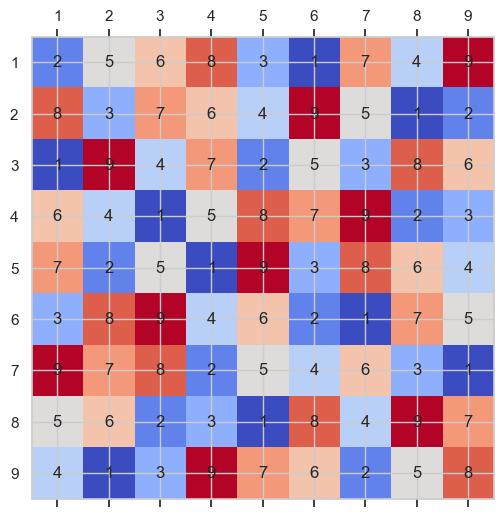

In [55]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from typing import List, Tuple

# Set the aesthetics for the plot
sns.set(style="whitegrid", palette="pastel", color_codes=True)

# Simple Sudoku class to handle Sudoku puzzles
class Sudoku:
    def __init__(self, sudoku_string: str):
        self.np_Sudoku = self.parse_sudoku_string(sudoku_string)
    
    @staticmethod
    def parse_sudoku_string(sudoku_string: str) -> np.ndarray:
        lines = sudoku_string.strip().split()
        board = [[int(char) for char in line] for line in lines]
        return np.array(board)

def get_nine_blocks(np_Sudoku):
    nine_blocks = []
    for i in range(3):
        for j in range(3):
            block = np_Sudoku[i*3:(i+1)*3, j*3:(j+1)*3]
            nine_blocks.append(block)
    return nine_blocks

def convert_nine_blocks_to_sukudo(nine_blocks):
    np_Sudoku = np.zeros((9, 9), dtype=int)
    for i in range(3):
        for j in range(3):
            np_Sudoku[i*3:(i+1)*3, j*3:(j+1)*3] = nine_blocks[i*3 + j]
    return np_Sudoku

def which_block_it_is(row, col):
    return (row // 3) * 3 + (col // 3)

def mask_for_given_sudoku_val(np_Sudoku):
    return (np_Sudoku != 0).astype(int)

def generate_empty_coord(board):
    return [(i, j) for i in range(9) for j in range(9) if board[i, j] == 0]

def show_sudoku_filled(sudoku):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(sudoku, cmap='coolwarm')

    for i in range(9):
        for j in range(9):
            c = sudoku[j, i]
            if c != 0:
                ax.text(i, j, str(c), va='center', ha='center')

    plt.xticks(np.arange(9), labels=np.arange(1, 10))
    plt.yticks(np.arange(9), labels=np.arange(1, 10))
    plt.show()

def get_error_from_updated_sukudo(sudoku):
    error_count = 0
    for i in range(9):
        error_count += 9 - len(set(sudoku[i, :]))
        error_count += 9 - len(set(sudoku[:, i]))
    for block in get_nine_blocks(sudoku):
        error_count += 9 - len(set(block.flatten()))
    return error_count, sudoku

def randomly_flip_numbers_in_a_block(np_Sudoku, nine_block_masks, block_num):
    updated_sudoku_9_blocks = get_nine_blocks(np_Sudoku)
    one_block_mask = nine_block_masks[block_num]
    row_col_combo_unfilled = return_row_col_combo_unfilled(one_block_mask)
    swap_position1 = random.choice(row_col_combo_unfilled)
    row_col_combo_unfilled.remove(swap_position1)
    swap_position2 = random.choice(row_col_combo_unfilled)
    tmp = updated_sudoku_9_blocks[block_num][swap_position1[0]][swap_position1[1]]
    updated_sudoku_9_blocks[block_num][swap_position1[0]][swap_position1[1]] = updated_sudoku_9_blocks[block_num][swap_position2[0]][swap_position2[1]]
    updated_sudoku_9_blocks[block_num][swap_position2[0]][swap_position2[1]] = tmp
    updated_soduku = convert_nine_blocks_to_sukudo(updated_sudoku_9_blocks)
    return updated_soduku

def return_row_col_combo_unfilled(one_block_mask):
    row_col_combo_unfilled = list()
    for row in range(3):
        for col in range(3):
            if one_block_mask[row][col] == 0:
                row_col_combo_unfilled.append((row, col))
    return row_col_combo_unfilled

def fill_in_np_sudoku(np_Sudoku, empty_coord):
    nine_blocks = get_nine_blocks(np_Sudoku)
    for key in empty_coord:
        block_num = which_block_it_is(key[0], key[1])
        nums_to_choose = list(range(1, 10))
        nums_to_choose = [i for i in nums_to_choose if i not in set(list(nine_blocks[block_num].ravel()))]
        num_to_fill = np.random.choice(nums_to_choose)
        np_Sudoku[key[0]][key[1]] = num_to_fill
    return np_Sudoku

def cross_over(for_cross_over):
    new_cross_over_boards = list()
    new_cross_over_boards.append(np.concatenate((for_cross_over[-1][:6], for_cross_over[0][6:]), axis=0))
    for i in range(len(for_cross_over) - 1):
        new_solution = np.concatenate((for_cross_over[i][:6], for_cross_over[i + 1][6:]), axis=0)
        new_cross_over_boards.append(new_solution)
    return new_cross_over_boards

def mutation(for_mutation, nine_block_mask):
    new_mutation_boards = list()
    for board in for_mutation:
        block_num = random.choice(range(9))
        new_mutation_boards.append(randomly_flip_numbers_in_a_block(board, nine_block_mask, block_num))
    return new_mutation_boards

def genetic_algorithm(startingSudoku, population_size=100, max_generation=5000):
    start = time()
    sudoku_obj = Sudoku(startingSudoku)
    sudoku_mask = mask_for_given_sudoku_val(sudoku_obj.np_Sudoku)
    nine_block_mask = get_nine_blocks(sudoku_mask)
    generation = 0
    boards_to_solve = [sudoku_obj.np_Sudoku.copy() for _ in range(population_size)]
    empty_coord_lst = [generate_empty_coord(board) for board in boards_to_solve]
    updated_boards = [fill_in_np_sudoku(board, coord) for (board, coord) in zip(boards_to_solve, empty_coord_lst)]

    for generation in range(max_generation):
        updated_boards_errors = [get_error_from_updated_sukudo(board)[0] for board in updated_boards]
        updated_boards_ordered = [board for board in map(lambda x: x[1], sorted(zip(updated_boards_errors, updated_boards), key=lambda x: x[0]))]
        min_error = get_error_from_updated_sukudo(updated_boards_ordered[0])[0]

        if min_error == 0:
            end = time()
            print(f"Solved in generation {generation}, time used is {end-start}")
            show_sudoku_filled(updated_boards_ordered[0])
            break
        else:
            new_gen = list()
            elite = updated_boards_ordered[: int(0.2 * population_size)]
            new_gen.extend(elite)
            for_cross_over = random.sample(updated_boards_ordered, int(0.4 * population_size))
            new_gen.extend(cross_over(for_cross_over))
            for_mutation = random.sample(updated_boards_ordered, int(0.4 * population_size))
            new_gen.extend(mutation(for_mutation, nine_block_mask))
            updated_boards = new_gen

            generation += 1

    if generation == max_generation:
        print(f"not solved, min error is {min_error}")
        return updated_boards_ordered[0]

# Example Sudoku puzzle
startingSudoku1 = """
                    206000049
                    037009000
                    100700006
                    000580900
                    705000804
                    009062000
                    900004001
                    000300490
                    410000208
                """

# Run the genetic algorithm
genetic_algorithm(startingSudoku1, population_size=25000, max_generation=50000)

Solved in generation 123, time used is 416.18440413475037


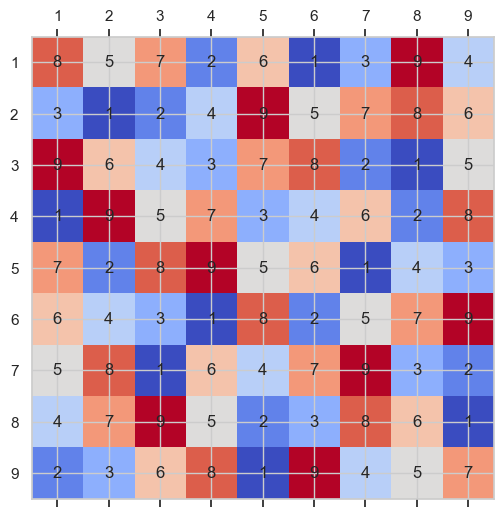

In [59]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from typing import List, Tuple

# Set the aesthetics for the plot
sns.set(style="whitegrid", palette="pastel", color_codes=True)

# Simple Sudoku class to handle Sudoku puzzles
class Sudoku:
    def __init__(self, sudoku_string: str):
        self.np_Sudoku = self.parse_sudoku_string(sudoku_string)
    
    @staticmethod
    def parse_sudoku_string(sudoku_string: str) -> np.ndarray:
        lines = sudoku_string.strip().split()
        board = [[int(char) for char in line] for line in lines]
        return np.array(board)

def get_nine_blocks(np_Sudoku):
    nine_blocks = []
    for i in range(3):
        for j in range(3):
            block = np_Sudoku[i*3:(i+1)*3, j*3:(j+1)*3]
            nine_blocks.append(block)
    return nine_blocks

def convert_nine_blocks_to_sukudo(nine_blocks):
    np_Sudoku = np.zeros((9, 9), dtype=int)
    for i in range(3):
        for j in range(3):
            np_Sudoku[i*3:(i+1)*3, j*3:(j+1)*3] = nine_blocks[i*3 + j]
    return np_Sudoku

def which_block_it_is(row, col):
    return (row // 3) * 3 + (col // 3)

def mask_for_given_sudoku_val(np_Sudoku):
    return (np_Sudoku != 0).astype(int)

def generate_empty_coord(board):
    return [(i, j) for i in range(9) for j in range(9) if board[i, j] == 0]

def show_sudoku_filled(sudoku):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(sudoku, cmap='coolwarm')

    for i in range(9):
        for j in range(9):
            c = sudoku[j, i]
            if c != 0:
                ax.text(i, j, str(c), va='center', ha='center')

    plt.xticks(np.arange(9), labels=np.arange(1, 10))
    plt.yticks(np.arange(9), labels=np.arange(1, 10))
    plt.show()

def get_error_from_updated_sukudo(sudoku):
    error_count = 0
    for i in range(9):
        error_count += 9 - len(set(sudoku[i, :]))
        error_count += 9 - len(set(sudoku[:, i]))
    for block in get_nine_blocks(sudoku):
        error_count += 9 - len(set(block.flatten()))
    return error_count, sudoku

def randomly_flip_numbers_in_a_block(np_Sudoku, nine_block_masks, block_num):
    updated_sudoku_9_blocks = get_nine_blocks(np_Sudoku)
    one_block_mask = nine_block_masks[block_num]
    row_col_combo_unfilled = return_row_col_combo_unfilled(one_block_mask)
    swap_position1 = random.choice(row_col_combo_unfilled)
    row_col_combo_unfilled.remove(swap_position1)
    swap_position2 = random.choice(row_col_combo_unfilled)
    tmp = updated_sudoku_9_blocks[block_num][swap_position1[0]][swap_position1[1]]
    updated_sudoku_9_blocks[block_num][swap_position1[0]][swap_position1[1]] = updated_sudoku_9_blocks[block_num][swap_position2[0]][swap_position2[1]]
    updated_sudoku_9_blocks[block_num][swap_position2[0]][swap_position2[1]] = tmp
    updated_soduku = convert_nine_blocks_to_sukudo(updated_sudoku_9_blocks)
    return updated_soduku

def return_row_col_combo_unfilled(one_block_mask):
    row_col_combo_unfilled = list()
    for row in range(3):
        for col in range(3):
            if one_block_mask[row][col] == 0:
                row_col_combo_unfilled.append((row, col))
    return row_col_combo_unfilled

def fill_in_np_sudoku(np_Sudoku, empty_coord):
    nine_blocks = get_nine_blocks(np_Sudoku)
    for key in empty_coord:
        block_num = which_block_it_is(key[0], key[1])
        nums_to_choose = list(range(1, 10))
        nums_to_choose = [i for i in nums_to_choose if i not in set(list(nine_blocks[block_num].ravel()))]
        num_to_fill = np.random.choice(nums_to_choose)
        np_Sudoku[key[0]][key[1]] = num_to_fill
    return np_Sudoku

def cross_over(for_cross_over):
    new_cross_over_boards = list()
    new_cross_over_boards.append(np.concatenate((for_cross_over[-1][:6], for_cross_over[0][6:]), axis=0))
    for i in range(len(for_cross_over) - 1):
        new_solution = np.concatenate((for_cross_over[i][:6], for_cross_over[i + 1][6:]), axis=0)
        new_cross_over_boards.append(new_solution)
    return new_cross_over_boards

def mutation(for_mutation, nine_block_mask):
    new_mutation_boards = list()
    for board in for_mutation:
        block_num = random.choice(range(9))
        new_mutation_boards.append(randomly_flip_numbers_in_a_block(board, nine_block_mask, block_num))
    return new_mutation_boards

def genetic_algorithm(startingSudoku, population_size=100, max_generation=5000):
    start = time()
    sudoku_obj = Sudoku(startingSudoku)
    sudoku_mask = mask_for_given_sudoku_val(sudoku_obj.np_Sudoku)
    nine_block_mask = get_nine_blocks(sudoku_mask)
    generation = 0
    boards_to_solve = [sudoku_obj.np_Sudoku.copy() for _ in range(population_size)]
    empty_coord_lst = [generate_empty_coord(board) for board in boards_to_solve]
    updated_boards = [fill_in_np_sudoku(board, coord) for (board, coord) in zip(boards_to_solve, empty_coord_lst)]

    for generation in range(max_generation):
        updated_boards_errors = [get_error_from_updated_sukudo(board)[0] for board in updated_boards]
        updated_boards_ordered = [board for board in map(lambda x: x[1], sorted(zip(updated_boards_errors, updated_boards), key=lambda x: x[0]))]
        min_error = get_error_from_updated_sukudo(updated_boards_ordered[0])[0]

        if min_error == 0:
            end = time()
            print(f"Solved in generation {generation}, time used is {end-start}")
            show_sudoku_filled(updated_boards_ordered[0])
            break
        else:
            new_gen = list()
            elite = updated_boards_ordered[: int(0.2 * population_size)]
            new_gen.extend(elite)
            for_cross_over = random.sample(updated_boards_ordered, int(0.4 * population_size))
            new_gen.extend(cross_over(for_cross_over))
            for_mutation = random.sample(updated_boards_ordered, int(0.4 * population_size))
            new_gen.extend(mutation(for_mutation, nine_block_mask))
            updated_boards = new_gen

            generation += 1

    if generation == max_generation:
        print(f"not solved, min error is {min_error}")
        return updated_boards_ordered[0]

# Example Sudoku puzzle
startingSudoku1 = """
                    050200000
                    300005080
                    960078200
                    000030020
                    708000103
                    040080000
                    001640032
                    070500001
                    000009050
                """

# Run the genetic algorithm
genetic_algorithm(startingSudoku1, population_size=25000, max_generation=50000)

Solved in generation 346, time used is 960.5519788265228


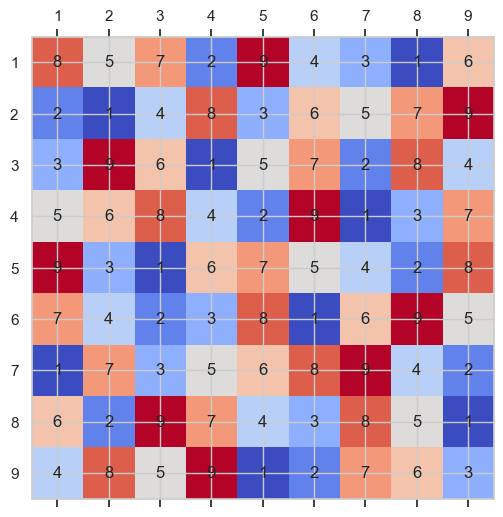

In [60]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from typing import List, Tuple

# Set the aesthetics for the plot
sns.set(style="whitegrid", palette="pastel", color_codes=True)

# Simple Sudoku class to handle Sudoku puzzles
class Sudoku:
    def __init__(self, sudoku_string: str):
        self.np_Sudoku = self.parse_sudoku_string(sudoku_string)
    
    @staticmethod
    def parse_sudoku_string(sudoku_string: str) -> np.ndarray:
        lines = sudoku_string.strip().split()
        board = [[int(char) for char in line] for line in lines]
        return np.array(board)

def get_nine_blocks(np_Sudoku):
    nine_blocks = []
    for i in range(3):
        for j in range(3):
            block = np_Sudoku[i*3:(i+1)*3, j*3:(j+1)*3]
            nine_blocks.append(block)
    return nine_blocks

def convert_nine_blocks_to_sukudo(nine_blocks):
    np_Sudoku = np.zeros((9, 9), dtype=int)
    for i in range(3):
        for j in range(3):
            np_Sudoku[i*3:(i+1)*3, j*3:(j+1)*3] = nine_blocks[i*3 + j]
    return np_Sudoku

def which_block_it_is(row, col):
    return (row // 3) * 3 + (col // 3)

def mask_for_given_sudoku_val(np_Sudoku):
    return (np_Sudoku != 0).astype(int)

def generate_empty_coord(board):
    return [(i, j) for i in range(9) for j in range(9) if board[i, j] == 0]

def show_sudoku_filled(sudoku):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(sudoku, cmap='coolwarm')

    for i in range(9):
        for j in range(9):
            c = sudoku[j, i]
            if c != 0:
                ax.text(i, j, str(c), va='center', ha='center')

    plt.xticks(np.arange(9), labels=np.arange(1, 10))
    plt.yticks(np.arange(9), labels=np.arange(1, 10))
    plt.show()

def get_error_from_updated_sukudo(sudoku):
    error_count = 0
    for i in range(9):
        error_count += 9 - len(set(sudoku[i, :]))
        error_count += 9 - len(set(sudoku[:, i]))
    for block in get_nine_blocks(sudoku):
        error_count += 9 - len(set(block.flatten()))
    return error_count, sudoku

def randomly_flip_numbers_in_a_block(np_Sudoku, nine_block_masks, block_num):
    updated_sudoku_9_blocks = get_nine_blocks(np_Sudoku)
    one_block_mask = nine_block_masks[block_num]
    row_col_combo_unfilled = return_row_col_combo_unfilled(one_block_mask)
    swap_position1 = random.choice(row_col_combo_unfilled)
    row_col_combo_unfilled.remove(swap_position1)
    swap_position2 = random.choice(row_col_combo_unfilled)
    tmp = updated_sudoku_9_blocks[block_num][swap_position1[0]][swap_position1[1]]
    updated_sudoku_9_blocks[block_num][swap_position1[0]][swap_position1[1]] = updated_sudoku_9_blocks[block_num][swap_position2[0]][swap_position2[1]]
    updated_sudoku_9_blocks[block_num][swap_position2[0]][swap_position2[1]] = tmp
    updated_soduku = convert_nine_blocks_to_sukudo(updated_sudoku_9_blocks)
    return updated_soduku

def return_row_col_combo_unfilled(one_block_mask):
    row_col_combo_unfilled = list()
    for row in range(3):
        for col in range(3):
            if one_block_mask[row][col] == 0:
                row_col_combo_unfilled.append((row, col))
    return row_col_combo_unfilled

def fill_in_np_sudoku(np_Sudoku, empty_coord):
    nine_blocks = get_nine_blocks(np_Sudoku)
    for key in empty_coord:
        block_num = which_block_it_is(key[0], key[1])
        nums_to_choose = list(range(1, 10))
        nums_to_choose = [i for i in nums_to_choose if i not in set(list(nine_blocks[block_num].ravel()))]
        num_to_fill = np.random.choice(nums_to_choose)
        np_Sudoku[key[0]][key[1]] = num_to_fill
    return np_Sudoku

def cross_over(for_cross_over):
    new_cross_over_boards = list()
    new_cross_over_boards.append(np.concatenate((for_cross_over[-1][:6], for_cross_over[0][6:]), axis=0))
    for i in range(len(for_cross_over) - 1):
        new_solution = np.concatenate((for_cross_over[i][:6], for_cross_over[i + 1][6:]), axis=0)
        new_cross_over_boards.append(new_solution)
    return new_cross_over_boards

def mutation(for_mutation, nine_block_mask):
    new_mutation_boards = list()
    for board in for_mutation:
        block_num = random.choice(range(9))
        new_mutation_boards.append(randomly_flip_numbers_in_a_block(board, nine_block_mask, block_num))
    return new_mutation_boards

def genetic_algorithm(startingSudoku, population_size=100, max_generation=5000):
    start = time()
    sudoku_obj = Sudoku(startingSudoku)
    sudoku_mask = mask_for_given_sudoku_val(sudoku_obj.np_Sudoku)
    nine_block_mask = get_nine_blocks(sudoku_mask)
    generation = 0
    boards_to_solve = [sudoku_obj.np_Sudoku.copy() for _ in range(population_size)]
    empty_coord_lst = [generate_empty_coord(board) for board in boards_to_solve]
    updated_boards = [fill_in_np_sudoku(board, coord) for (board, coord) in zip(boards_to_solve, empty_coord_lst)]

    for generation in range(max_generation):
        updated_boards_errors = [get_error_from_updated_sukudo(board)[0] for board in updated_boards]
        updated_boards_ordered = [board for board in map(lambda x: x[1], sorted(zip(updated_boards_errors, updated_boards), key=lambda x: x[0]))]
        min_error = get_error_from_updated_sukudo(updated_boards_ordered[0])[0]

        if min_error == 0:
            end = time()
            print(f"Solved in generation {generation}, time used is {end-start}")
            show_sudoku_filled(updated_boards_ordered[0])
            break
        else:
            new_gen = list()
            elite = updated_boards_ordered[: int(0.2 * population_size)]
            new_gen.extend(elite)
            for_cross_over = random.sample(updated_boards_ordered, int(0.4 * population_size))
            new_gen.extend(cross_over(for_cross_over))
            for_mutation = random.sample(updated_boards_ordered, int(0.4 * population_size))
            new_gen.extend(mutation(for_mutation, nine_block_mask))
            updated_boards = new_gen

            generation += 1

    if generation == max_generation:
        print(f"not solved, min error is {min_error}")
        return updated_boards_ordered[0]

# Example Sudoku puzzle
startingSudoku1 = """
                    050090000
                    004800009
                    000107280
                    560000137
                    000000000
                    040080000
                    173000042
                    600003800
                    000010060
                """

# Run the genetic algorithm
genetic_algorithm(startingSudoku1, population_size=25000, max_generation=50000)